In [0]:
import pandas as pd
import numpy as np
from google.colab import files, drive
import io
from fastai.vision import *
from fastai.metrics import error_rate
import torch

In [0]:
# set device to gpu if available 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from google.colab import drive

# have fashion dataset on google drive, going to upload from there
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!ls "/content/drive/My Drive/fashion-dataset"

data_part1.csv	images	images.csv  styles  styles_clean.csv  styles.csv


In [0]:
data = pd.read_csv("/content/drive/My Drive/fashion-dataset/styles_clean.csv")

In [6]:
data.head()
# looks like it all got loaded correctly

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,Unnamed: 10,Unnamed: 11
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,NaN,NaN
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,NaN,NaN
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,NaN,NaN
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,NaN,NaN
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,NaN,NaN


In [0]:
batchsize = 64

In [0]:
# had to get specific version of torch and torch vision to work with fastai or else a ton of warnings appear .
# only have to run once per runtime
#!pip install "torch==1.4" "torchvision==0.5.0"

In [0]:
# after an hour and a half of training the cnn, found out there are some 
# ids that don't have an associated image (ugh). Going to have to remove those

from pathlib import Path

for id in data['id']:
  file = Path(f'/content/drive/My Drive/fashion-dataset/images/{id}.jpg')

  # not file exists wasn't working so I just check if its true and then continue
  if file.exists():
    continue

  # set the dataset to itself without the entry without a related image
  data = data.loc[data['id'] != id]

In [23]:
# check to make sure it worked, should output an empty DataFrame
print(data.loc[data['id'] == 39410])

# check to make sure other values are still there
print(data.head())

Empty DataFrame
Columns: [id, gender, masterCategory, subCategory, articleType, baseColour, season, year, usage, productDisplayName, Unnamed: 10, Unnamed: 11]
Index: []
      id gender  ... Unnamed: 10 Unnamed: 11
0  15970    Men  ...         NaN         NaN
1  39386    Men  ...         NaN         NaN
2  59263  Women  ...         NaN         NaN
3  21379    Men  ...         NaN         NaN
4  53759    Men  ...         NaN         NaN

[5 rows x 12 columns]


In [24]:
# Set up image batches. 
# label_col: what we are going to be predicting
# valid_pct: percent of data that should be held out for validation
cnn_data = ImageDataBunch.from_df(df=data, label_col='articleType', path='/content/drive/My Drive/fashion-dataset/images/', suffix='.jpg', bs=batchsize,
                                  ds_tfms=get_transforms(), size=224, valid_pct=.2, device=device)

/usr/local/lib/python3.6/dist-packages/fastai/data_block.py:541: UserWarning: You are labelling your items with CategoryList.
Your valid set contained the following unknown labels, the corresponding items have been discarded.
Hair Accessory, Mens Grooming Kit
  if getattr(ds, 'warn', False): warn(ds.warn)


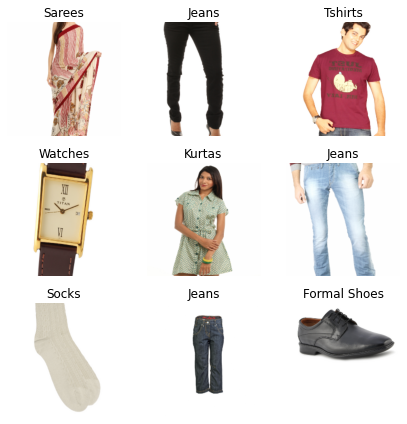

In [25]:
cnn_data.show_batch(rows=3, figsize=(6,6))

In [26]:
# going to be using a reset34 to hopefully speed up train time as much as possible
model = cnn_learner(cnn_data, models.resnet34, metrics=error_rate)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


In [27]:
# train/ test model for one cycle 
model.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.861635,0.598874,0.178145,3:40:58


In [0]:
#not too bad i guess
# had a score of .86 on the train and .59 on validation in just under 4 hours 